In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os as os
import math


### Carga de datos

In [3]:

#TODO Introducir el dataset con el que se vaya a trabajar
station = 'hugo'
input_path = f'{station}_clean.csv'


df = pd.read_csv(f'data_{station}/{input_path}', parse_dates=['date'])
cols = [col for col in df.columns]

for col in df.columns:
    if col != 'date':  
        df[col] = pd.to_numeric(df[col], errors='coerce')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56976 entries, 0 to 56975
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   temp    52782 non-null  float64       
 1   pres    37309 non-null  float64       
 2   vel     26779 non-null  float64       
 3   dir     26779 non-null  float64       
 4   hr      29825 non-null  float64       
 5   date    56976 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(5)
memory usage: 2.6 MB


### Ventana móvil

Ventana móvil con 2 fases.
1. Marca la "frontera" de los periodos válidos mirando hacia atrás. Marcará un 1 si el periodo de 365 días anterior es válido.
2. Refrescar el periodo de 365 días anterior a cada "flag" que tenga un 1, para marcar que el periodo ya es válido.

In [16]:

window_size = 365 * 24  
nulls_tolerance = 15 * 24 # 2 semanas horario
value_counts = pd.DataFrame()

#Nos saltamos la columna de fecha e identificacion de la base
for col in df.columns:
    if df[col].dtype != np.float64 and df[col].dtype != np.int64:        
        print(f'{col} is not a number')
        continue
    print(f'{col} is a number')
    df[f'{col}_{station}'] = df[col].rolling(window=window_size, min_periods=1).apply(
        lambda x: 0 if x.isnull().sum() > nulls_tolerance or len(x) < window_size else 1
    )
    df[f'{col}_{station}'] = df[f'{col}_{station}'].replace({np.nan: 0})
    df[f'{col}_{station}'] = df[f'{col}_{station}'].astype(np.int8)

    value_counts[col] = df[f'{col}_{station}'].value_counts().reindex([0, 1], fill_value=0)


temp is a number
pres is a number
vel is a number
dir is a number
hr is a number
date is not a number
temp_hugo is not a number
pres_hugo is not a number
vel_hugo is not a number
dir_hugo is not a number
hr_hugo is not a number
       temp  pres  vel  dir  hr                date  temp_hugo  pres_hugo  \
56956   NaN   NaN  NaN  NaN NaN 2016-02-29 04:00:00          0          1   
56957   NaN   NaN  NaN  NaN NaN 2016-02-29 05:00:00          0          1   
56958   NaN   NaN  NaN  NaN NaN 2016-02-29 06:00:00          0          1   
56959   NaN   NaN  NaN  NaN NaN 2016-02-29 07:00:00          0          1   
56960   NaN   NaN  NaN  NaN NaN 2016-02-29 08:00:00          0          1   
56961   NaN   NaN  NaN  NaN NaN 2016-02-29 09:00:00          0          1   
56962   NaN   NaN  NaN  NaN NaN 2016-02-29 10:00:00          0          1   
56963   NaN   NaN  NaN  NaN NaN 2016-02-29 11:00:00          0          1   
56964   NaN   NaN  NaN  NaN NaN 2016-02-29 12:00:00          0          1   
56

In [23]:
for i in range(len(df['hr_hugo'])):
    if df.iloc[i, df.columns.get_loc("hr_hugo")] == 1:  # Acceder al valor de 'hr_hugo' usando iloc
        start_idx = max(0, i - window_size + 1)  # Asegúrate de no salirte del índice negativo
        
        # Actualizar los valores de los últimos 365 días (o el tamaño de la ventana)
        df.loc[start_idx:i, 'hr_hugo'] = 1  # Asignar 1 a la columna 'hr_hugo' en ese rango de índices


In [29]:
for col in df.columns:
    if col.endswith(station):        
        print(f'{col} va a ser reasignada ')
        for i in range(len(df[col])):
            if df.iloc[i, df.columns.get_loc(col)] == 1:  # Acceder al valor de 'hr_hugo' usando iloc
                start_idx = max(0, i - window_size + 1)  # Asegúrate de no salirte del índice negativo
                
                df.loc[start_idx:i, col] = 1  # Asignar 1 a la columna 'hr_hugo' en ese rango de índices
    else:
        print(f'{col} NO va a ser reasignada ---> ')
        continue

temp NO va a ser reasignada --->  0                               NaN
1                               NaN
2                               NaN
3                               NaN
4                               NaN
                                 ..
1952-02-02 00:00:00.000000044   NaN
1952-02-03 00:00:00.000000044   NaN
1952-02-04 00:00:00.000000044   NaN
1952-02-05 00:00:00.000000044   NaN
1952-02-06 00:00:00.000000044   NaN
Name: temp, Length: 71431, dtype: float64
pres NO va a ser reasignada --->  0                               NaN
1                               NaN
2                               NaN
3                               NaN
4                               NaN
                                 ..
1952-02-02 00:00:00.000000044   NaN
1952-02-03 00:00:00.000000044   NaN
1952-02-04 00:00:00.000000044   NaN
1952-02-05 00:00:00.000000044   NaN
1952-02-06 00:00:00.000000044   NaN
Name: pres, Length: 71431, dtype: float64
vel NO va a ser reasignada --->  0                      

TypeError: cannot do slice indexing on Index with these indexers [56976] of type int

In [19]:
# Exportación

df.to_csv(f'data_{station}/{station}_flagged.csv', index=False)

### Visualización de los datos

temp
pres
vel
dir
hr
temp_hugo
pres_hugo
vel_hugo
dir_hugo
hr_hugo


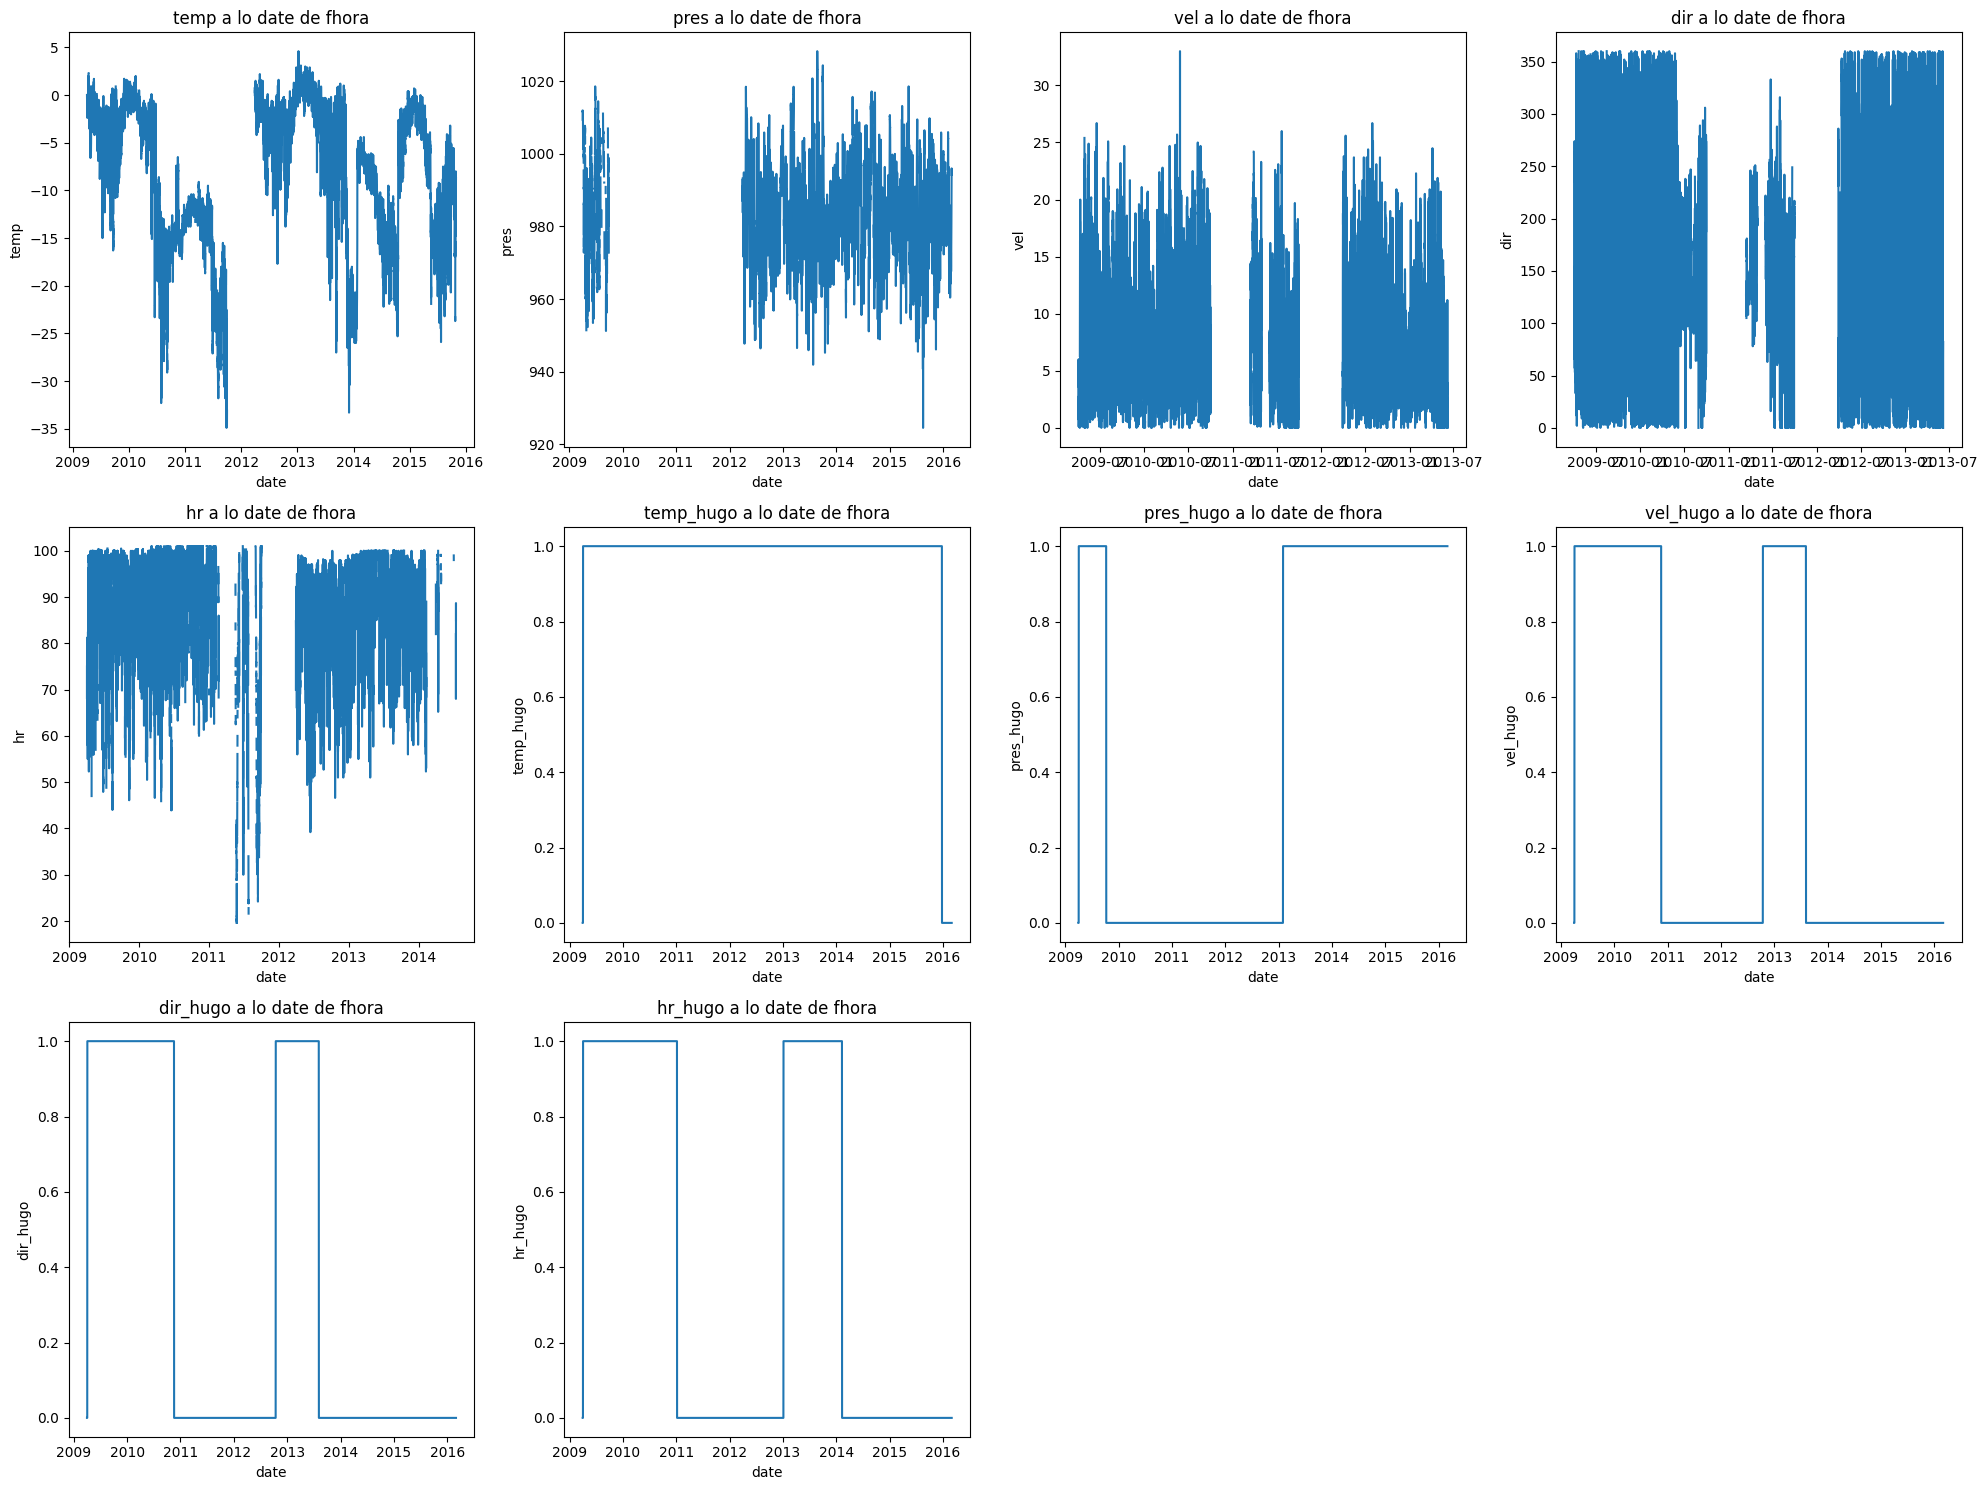

In [17]:

num_cols = len(df.columns) - 1  # Restamos 1 para excluir la columna 'fhora'
num_rows = math.ceil(num_cols / 4)  # Redondea hacia arriba para obtener el número de filas necesarias

fig, axes = plt.subplots(nrows=num_rows, ncols=4, figsize=(20, 5 * num_rows))  # Ajusta el tamaño de la figura según el número de filas


# Aplanar el array de ejes para poder iterar sobre él
axes = axes.flatten()

# Iterar sobre las columnas (excluyendo 'fhora') y generar gráficos
for ax, col in zip(axes, df.columns.drop('date')):
    print(col)
    ax.plot(df['date'], df[col])
    ax.set_xlabel('date')
    ax.set_ylabel(col)
    ax.set_title(f'{col} a lo date de fhora')

# Eliminar los ejes sobrantes si el número de columnas no es múltiplo de 4
if num_cols % 4:
    for ax in axes[num_cols:]:
        ax.remove()

plt.tight_layout()
plt.savefig(f'resource/flagged_{station}.png')

plt.show()

In [12]:
df['hr'].iloc[5000:5050].head(50)

5000    81.6
5001    77.0
5002    75.0
5003    77.0
5004    86.0
5005     NaN
5006    91.1
5007    93.9
5008     NaN
5009    95.1
5010    94.8
5011    96.9
5012    97.2
5013    98.0
5014    98.0
5015    99.0
5016    99.0
5017    99.0
5018    98.1
5019    98.0
5020    97.2
5021    96.0
5022    93.2
5023    94.0
5024    93.0
5025    90.2
5026    90.0
5027     NaN
5028    87.4
5029    78.0
5030     NaN
5031    76.0
5032    77.7
5033     NaN
5034    73.0
5035     NaN
5036    80.9
5037    73.2
5038     NaN
5039    77.0
5040     NaN
5041    82.2
5042    77.0
5043    88.0
5044    86.0
5045    88.1
5046    77.6
5047    69.8
5048    88.0
5049    87.4
Name: hr, dtype: float64

### Generación de Heatmap

C:\Users\Administrador.CRISASUSESTUDIO\AppData\Local\Temp\ipykernel_14648\2938838878.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flags['date'] = df['date']


5 2
hr_ferraz procede al mapa de calor
prec_ferraz procede al mapa de calor
pres_ferraz procede al mapa de calor
temp_ferraz procede al mapa de calor
dir_ferraz procede al mapa de calor
vel_ferraz procede al mapa de calor


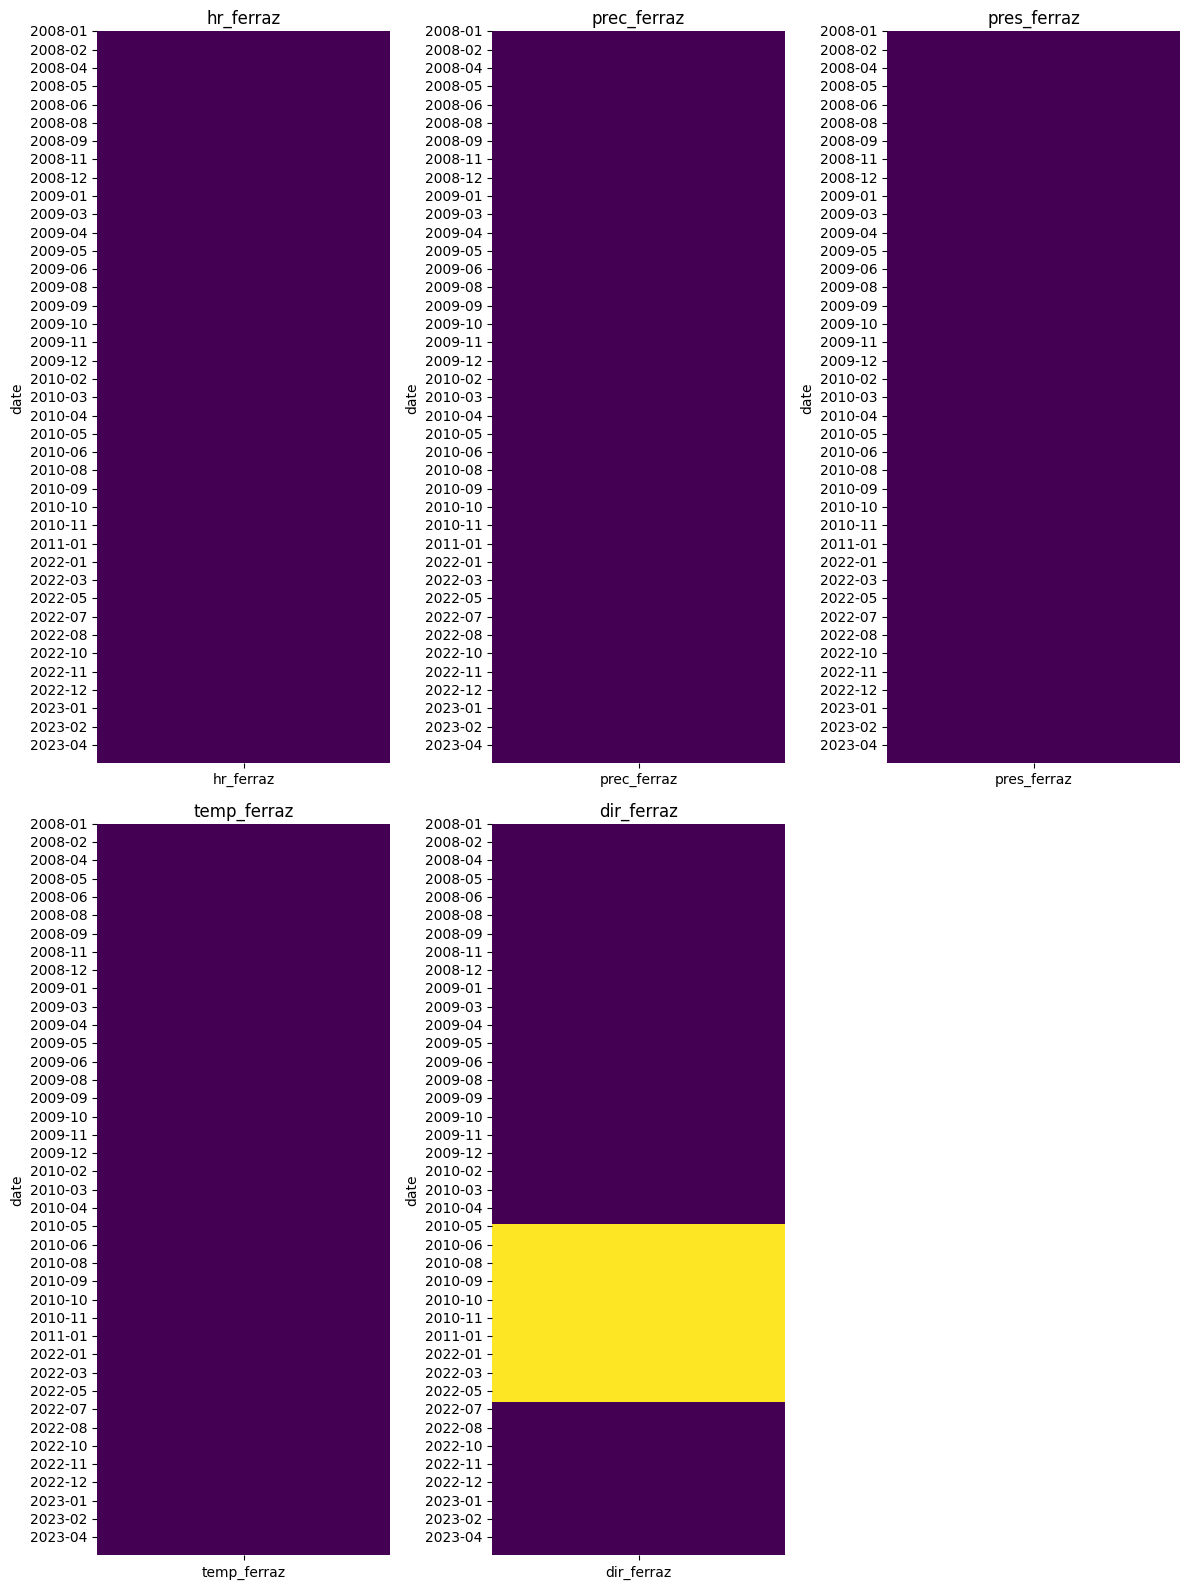

,date,hr,prec,pres,temp,dir,vel,hr_ferraz,prec_ferraz,pres_ferraz,temp_ferraz,dir_ferraz,vel_ferraz
0,2008-01-18 00:00:00,NaN,NaN,NaN,NaN,NaN,nan,0,0,0,0,0,0
1,2008-01-18 01:00:00,NaN,NaN,NaN,NaN,NaN,nan,0,0,0,0,0,0
2,2008-01-18 02:00:00,NaN,NaN,NaN,NaN,NaN,nan,0,0,0,0,0,0
3,2008-01-18 03:00:00,NaN,NaN,NaN,NaN,NaN,nan,0,0,0,0,0,0
4,2008-01-18 04:00:00,NaN,NaN,NaN,NaN,NaN,nan,0,0,0,0,0,0


In [15]:

df_flags = df[[col for col in df.columns if station in col]]
df_flags['date'] = df['date']

df_flags.set_index('date', inplace=True)
df_flags.index = pd.to_datetime(df_flags.index)
df_flags.index = df_flags.index.to_period('M') 

num_cols = len(df_flags.columns)-1

num_rows = math.ceil(num_cols / 3)  
print(num_cols, num_rows)

fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(12, 8 * num_rows))  # Ajusta el tamaño de la figura según el número de filas

# Aplanar el array de ejes para poder iterar sobre él
axes = axes.flatten()

# Iterar sobre las columnas y generar gráficos
for ax, col in zip(axes, df_flags.columns):
    if col != 'date':
        print(f'{col} procede al mapa de calor')
        sns.heatmap(df_flags[[col]], cbar=False, cmap='viridis', ax=ax)
        ax.set_title(col)
    

# Eliminar los ejes sobrantes si el número de columnas no es múltiplo de 3
if num_cols % 3:
    for ax in axes[num_cols:]:
        ax.remove()

plt.tight_layout()
plt.savefig(f'resource/heatmap_{station}_window.png')
plt.show()

df.head()

In [41]:
df_seleccion_periodo = df[['gdc_ts', 'ts']].loc['2015-01-01':'2015-03-01']
df_seleccion_periodo.to_csv('periodo_seleccionado.csv')

### Código para examinar una sola columna de forma individual

In [5]:
df_2006 = pd.read_json(f'data_{station}/{station}_2006.json')
df_2006.head()

,identificacion,nombre,latitud,longitud,altitud,srs,alt_nieve,ddd,dddstd,dddx,...,global,ir_solar,neta,par,tcielo,ttierra,uvab,uvb,uvi,qdato
0,89070,GdC Estacion meteorologica,-62.97697,-60.67528,12,WGS84,0,334,0,0,...,0,0,0,0,0,0,0,0,0,0
1,89070,GdC Estacion meteorologica,-62.97697,-60.67528,12,WGS84,0,333,0,0,...,0,0,0,0,0,0,0,0,0,0
2,89070,GdC Estacion meteorologica,-62.97697,-60.67528,12,WGS84,0,340,0,0,...,0,0,0,0,0,0,0,0,0,0
3,89070,GdC Estacion meteorologica,-62.97697,-60.67528,12,WGS84,0,342,0,0,...,0,0,0,0,0,0,0,0,0,0
4,89070,GdC Estacion meteorologica,-62.97697,-60.67528,12,WGS84,0,343,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
target = 'lluv'

plt.figure(figsize=(10, 6))
plt.plot(df_2006['fhora'], df_2006[f'{target}'])
plt.xlabel('fhora')
plt.ylabel(f'{target}')
plt.title(f'{target} a lo largo de fhora')
plt.show()